## **Landscape Data Preprocessing**

### **Import Dependencies**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio as rio
from rasterio.fill import fillnodata
import geopandas as gpd
import os
from glob import glob
from tqdm.auto import tqdm
import random

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = 'Times New Roman'

### **Define the Data Folder Paths**

In [2]:
# Define the image and mask file paths
image_paths = sorted(glob(r'e:\KRISHNA\GITHUB\landscape-classification\datasets\rasters\*\Images\*.tif'))
mask_paths = sorted(glob(r'e:\KRISHNA\GITHUB\landscape-classification\datasets\rasters\*\Masks\*.tif'))

print('Number of images:', len(image_paths))
print('Number of masks:', len(mask_paths))

Number of images: 97943
Number of masks: 97943


In [109]:
# Define the band names and class values
band_names = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12', 'VH', 'VV']
class_values = [111, 112, 121, 122, 123, 124, 131, 132, 133, 141, 142, 211, 212,
                213, 221, 222, 223, 231, 241, 242, 243, 244, 311, 312, 313, 321,
                322, 323, 324, 331, 332, 333, 334, 335, 411, 412, 421, 422, 423,
                511, 512, 521, 522, 523]

print('Band names:', band_names)
print('Class value:', class_values)

Band names: ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12', 'VH', 'VV']
Class value: [111, 112, 121, 122, 123, 124, 131, 132, 133, 141, 142, 211, 212, 213, 221, 222, 223, 231, 241, 242, 243, 244, 311, 312, 313, 321, 322, 323, 324, 331, 332, 333, 334, 335, 411, 412, 421, 422, 423, 511, 512, 521, 522, 523]


### **Data Pre-processing**

#### **Things Need to Evaluate**
1. Center LULC
2. Number of NaN values
3. Fill the Gaps if the Number of NaN values are less than 80%
4. Stratified Sampling around 100 points on each image

Image shape: (11, 256, 256), Mask shape: (3, 256, 256)


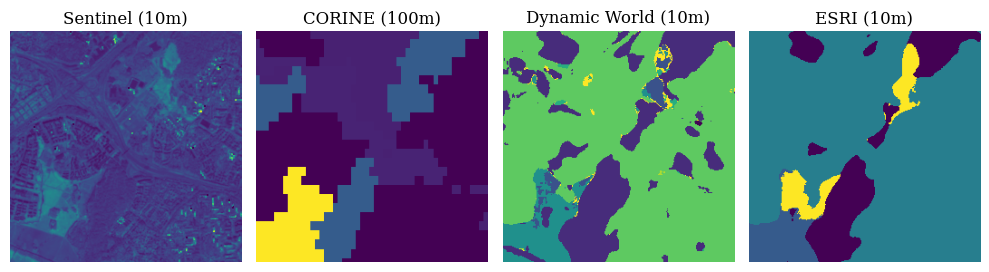

In [3]:
# Select a random image to test all the functions
random_id = random.randint(0, len(image_paths))

with rio.open(image_paths[random_id], 'r') as src:
    test_image = src.read()

with rio.open(mask_paths[random_id], 'r') as src:
    test_mask = src.read()

print(f'Image shape: {test_image.shape}, Mask shape: {test_mask.shape}')

# Plot the image and mask
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
labels = ['Sentinel (10m)', 'CORINE (100m)', 'Dynamic World (10m)', 'ESRI (10m)']
for i, ax in enumerate(axes.flat):
    if i == 0:
        img = test_image[6]
    elif i == 1:
        img = test_mask[0]
    elif i == 2:
        img = test_mask[1]
    elif i == 3:
        img = test_mask[2]  

    ax.imshow(img)
    ax.axis('off')
    ax.set_title(labels[i])

plt.tight_layout()
plt.show()

#### **Fill Data Gaps**

In [4]:
# Function to fill gaps in the data
def fillGaps(
    image_array: np.array, 
    band_ids: list,
    remaining_bands: list,
    nodata_value = 0,
    concat_remaining = False,
    pixel_count: int = 10,
    max_search_distance: int = 5, 
    smoothing_iterations: int = 0
    ): 
    
    """
    Fills gaps in specified bands of an image array using interpolation and optionally concatenates remaining bands.

    This function identifies gaps in the specified bands of an input image array based on a given no-data value. 
    It fills those gaps using a gap-filling algorithm, such as `fillnodata`, by interpolating valid neighboring pixels.
    Optionally, remaining bands can be concatenated to the gap-filled output.

    Parameters:
        image_array (np.array): A 3D array representing the image, with shape (bands, height, width).
        band_ids (list): Indices of the bands in `image_array` where gaps need to be filled.
        remaining_bands (list): Indices of the bands in `image_array` to include without modification.
        nodata_value (int or float, optional): The value used to represent missing data. Defaults to 0.
        concat_remaining (bool, optional): Whether to concatenate the `remaining_bands` with the gap-filled bands. Defaults to False.
        pixel_count (int, optional): The minimum number of valid pixels required to proceed with gap filling. Defaults to 10.
        max_search_distance (int, optional): The maximum distance (in pixels) to search for valid neighboring pixels during gap filling. Defaults to 5.
        smoothing_iterations (int, optional): The number of smoothing iterations to apply during gap filling. Defaults to 0.

    Returns:
        np.array: A 3D array containing the gap-filled bands, optionally concatenated with the remaining bands. 
        If the number of valid pixels is below `pixel_count`, the original `image_array` is returned.

    Notes:
        - This function assumes that the input array is ordered as (bands, height, width).
        - The `fillnodata` function must be implemented or imported. It is used to fill gaps in each band.
        - Ensure that `band_ids` and `remaining_bands` are valid indices within the input array.
    """

    # Extract the image bands from the array
    image_bands = image_array[band_ids]

    # Calculate the sum of pixel values accross the image
    image_bands_sum = image_bands.sum(axis=0)

    # Extract the NaN mask
    nodata_mask = np.where(image_bands_sum==nodata_value, 0, 1)

    # Fill gaps only if there are no data values
    if int(nodata_mask.sum()) < pixel_count:

        # Apply fill nodata across all all bands
        filled_data = np.empty_like(image_bands)

        for band in range(image_bands.shape[0]):
            filled_data[band] = fillnodata(
                image=image_bands[band],
                mask=nodata_mask,
                max_search_distance=max_search_distance,
                smoothing_iterations=smoothing_iterations
            )
        
        # Concatenate the remaining bands if needed
        if len(remaining_bands) > 0 and concat_remaining == True:
            filled_array = np.concatenate((filled_data, image_array[remaining_bands]), axis=0)

        return filled_array
    
    else:
        return image_array

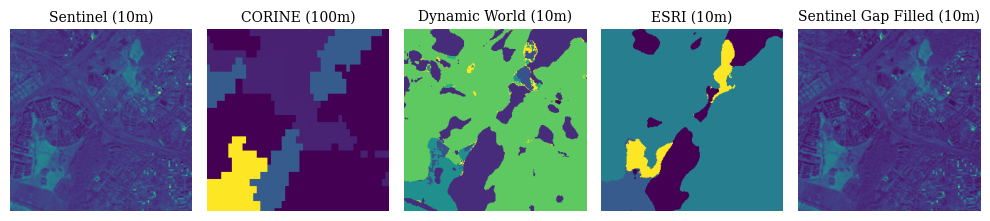

In [5]:
# Example usage
test_filled_array = fillGaps(test_image, 
                        band_ids=np.arange(0, 9), 
                        remaining_bands=[9, 10],
                        concat_remaining=True,
                        pixel_count=65536, 
                        max_search_distance=100)

# Plot the image, mask, and filled image
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 10))
labels = ['Sentinel (10m)', 'CORINE (100m)', 'Dynamic World (10m)', 'ESRI (10m)', 'Sentinel Gap Filled (10m)']
for i, ax in enumerate(axes.flat):
    if i == 0:
        img = test_image[6]
    elif i == 1:
        img = test_mask[0]
    elif i == 2:
        img = test_mask[1]
    elif i == 3:
        img = test_mask[2]
    else:
        img = test_filled_array[6]

    ax.imshow(img)
    ax.axis('off')
    ax.set_title(labels[i], fontsize=10)

plt.tight_layout()
plt.show()

#### **Stratified Sampling over Images**

In [6]:
# Function to perform stratified sampling on an image array
def stratified_sampling(image_array: np.array,
                        band_id: int = 0,
                        total_points: int = 100,
                        random_state = None):
    """
    Perform stratified sampling on an array of values.

    Parameters:
        array (np.array or list): Array of values to stratify.
        total_points (int): Total number of points to sample.
        random_state (int, optional): Seed for reproducibility.

    Returns:
        np.array: Array of sampled indices.
    """
    
    if random_state is not None:
        np.random.seed(random_state)

    # Convert the image into pandas data series
    data = pd.Series(image_array[band_id].flatten())

    # Get unique classes and their properties
    class_counts = data.value_counts()
    class_proportions = class_counts / len(data)

    # Calculate the number of samples for each class
    class_samples = (class_proportions * total_points).round().astype(int)

    # Perform sampling for each class
    sampled_indices = []

    for value, sample_count in class_samples.items():
        # Get indices of the current class
        class_indices = data[data==value].index
        # Randomly sample indices
        sampled_indices.extend(np.random.choice(class_indices, size=sample_count, replace=False))

    return np.array(sampled_indices)

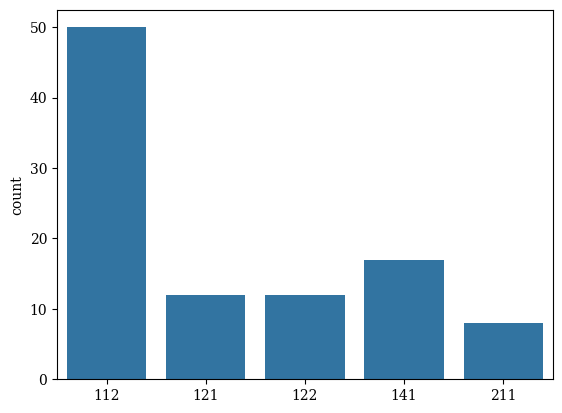

In [7]:
# Example usage
test_sampled_indices = stratified_sampling(test_mask, band_id=0, total_points=100)
test_sampled_values = test_mask[0].flatten()[test_sampled_indices]
test_sampled_value_counts = pd.Series(test_sampled_values).value_counts()

sns.barplot(test_sampled_value_counts);

#### **Implement all the Functions on the Dataset**

In [134]:
class CustomProcessing:

    # constructor
    def __init__(self, image_folder_path, mask_folder_path):
        self.image_folder_path = image_folder_path
        self.mask_folder_path = mask_folder_path

        self.image_f_paths = sorted(glob(self.image_folder_path + '\*.tif'))
        self.mask_f_paths = sorted(glob(self.mask_folder_path + '\*.tif'))

        self.len_images = len(self.image_f_paths)
        self.len_masks = len(self.mask_f_paths)

    def applyProcessing(self, country_out_dir):

        # Define all the directories
        image_out_dir = country_out_dir + '\\Images'
        mask_out_dir = country_out_dir + '\\Masks'
        csv_out_dir = country_out_dir + '\\CSVs'

        for p in [image_out_dir, mask_out_dir, csv_out_dir]:
            if os.path.exists(p)==False:
                os.makedirs(p)

        country_sample_stat = pd.DataFrame()
        class_value_counts_list = []
        
        # Iterate over image files
        for i, f in enumerate(self.image_f_paths[:5]):
            
            # -------------------------------------------------------------------------------------
            # Image loading
            # -------------------------------------------------------------------------------------
            # Read the image using rasterio
            image_id = f.split('\\')[-1].split("_")[0]
            image_name = '_'.join(f.split('\\')[-1].split("_")[:2])

            with rio.open(f, 'r') as src:
                image_array = src.read()
                image_array_filled = fillGaps(
                    image_array=image_array,
                    band_ids=np.arange(0, 9), 
                    remaining_bands=[9, 10],
                    concat_remaining=True,
                    pixel_count=65536, 
                    max_search_distance=100
                )
                image_array_filled = image_array_filled.astype(np.float32) # convert to float32

            # Read the mask using rasterio
            mask_f = self.mask_f_paths[i]
            mask_id = mask_f.split('\\')[-1].split("_")[0]
            if mask_id == image_id:
                with rio.open(mask_f, 'r') as src:
                    mask_array = src.read()
                    mask_array = mask_array.astype(np.float32) # convert to float32

            # -------------------------------------------------------------------------------------
            # Nodata Condition Checking
            # -------------------------------------------------------------------------------------
            # Extract the image bands from the array
            image_bands_sum = image_array[:9].sum(axis=0)

            # Extract the NaN mask and calculate the nodata percentage
            nodata_mask = np.where(image_bands_sum==0, 1, 0)
            nodata_perc = int(nodata_mask.sum()) / 65536

            # -------------------------------------------------------------------------------------
            # Stratified Sampling
            # -------------------------------------------------------------------------------------
            if nodata_perc <= 0.1:
                sample_indices = stratified_sampling(
                    image_array=mask_array,
                    band_id=0,
                    total_points=100,
                    random_state=None)
                
                image_samples = pd.DataFrame()
                image_samples['CORINE'] = mask_array[0].flatten()[sample_indices]
                image_samples['DW'] = mask_array[1].flatten()[sample_indices]
                image_samples['ESRI'] = mask_array[2].flatten()[sample_indices]

                for band_i, band in enumerate(band_names):
                    image_samples[band] = image_array_filled[band_i].flatten()[sample_indices]

                image_samples['Image_ID'] = image_id
                country_sample_stat = pd.concat((country_sample_stat, image_samples), axis=0, ignore_index=True)

                # ---------------------------------------------------------------------------------
                # Stratified Sampling
                # ---------------------------------------------------------------------------------
                # Extract the class value counts
                image_area_dict = {}
                mask_array_ds = pd.Series(mask_array[0].flatten()).astype(int)
                # Get unique classes and their properties
                class_counts = mask_array_ds.value_counts()
                for cl in class_values:
                    if cl in class_counts.keys():
                        image_area_dict[cl] = int(class_counts[cl])
                    else:
                        image_area_dict[cl] = 0

                image_area_dict['Image_ID'] = image_id
                image_area_dict['Center_Class'] = image_name.split("_")[1]

                class_value_counts_list.append(image_area_dict)

            else:
                continue

        # -------------------------------------------------------------------------------------
        # Prepare the CSVs
        # -------------------------------------------------------------------------------------
        class_value_counts_df = pd.DataFrame(class_value_counts_list)           

        # -------------------------------------------------------------------------------------
        # Save the images and csvs
        # -------------------------------------------------------------------------------------
        country_sample_stat.to_csv(os.path.join(csv_out_dir, f'country_samples_stat.csv'), index=False)
        class_value_counts_df.to_csv(os.path.join(csv_out_dir, f'class_value_count.csv'), index=False)
        np.save(os.path.join(image_out_dir, f'{image_name}_Image.npy'))
        np.save(os.path.join(image_out_dir, f'{image_name}_Mask.npy'))
            
        print('Data has been extracted successfully!')

In [135]:
custom_processing = CustomProcessing(country_image_folder_path, country_mask_folder_path)
country_sample_stat = custom_processing.applyProcessing(None)

In [136]:
country_sample_stat

,111,112,121,122,123,124,131,132,133,141,...,421,422,423,511,512,521,522,523,Image_ID,Center_Class
0,37921,15973,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,00000,111
1,16789,0,0,0,0,0,0,0,0,0,...,0,0,0,0,15952,0,0,0,00003,111
2,23115,6092,5850,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,00004,111


In [127]:
country_sample_stat.iloc[:, :-3]

,CORINE,DW,ESRI,B2,B3,B4,B5,B6,B7,B8,B11,B12
0,111.0,6.0,5.0,954.0,1345.0,1469.0,2403.0,2760.0,2915.0,3003.0,2999.0,2501.0
1,111.0,6.0,5.0,1293.0,1574.0,1712.0,1793.0,2323.0,2551.0,2352.0,2498.0,2124.0
2,111.0,6.0,5.0,1238.0,1206.0,2015.0,2132.0,2492.0,2730.0,2706.0,3177.0,2999.0
3,111.0,6.0,5.0,884.0,997.0,1116.0,1704.0,2217.0,2394.0,2491.0,2849.0,2396.0
4,111.0,6.0,5.0,2212.0,2519.0,2745.0,3081.0,3348.0,3515.0,3522.0,3507.0,3159.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,121.0,6.0,5.0,1040.0,1186.0,1383.0,1486.0,1592.0,1608.0,1623.0,2157.0,2048.0
96,121.0,6.0,5.0,796.0,994.0,1344.0,1493.0,1517.0,1579.0,1583.0,1879.0,1690.0
97,121.0,6.0,5.0,1071.0,1325.0,1493.0,1715.0,2103.0,2246.0,2175.0,2294.0,2148.0
98,121.0,6.0,5.0,1119.0,1327.0,1512.0,1500.0,1405.0,1468.0,1596.0,1643.0,1514.0


In [120]:
country_sample_stat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299 entries, 0 to 99
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CORINE    299 non-null    float32
 1   DW        299 non-null    float32
 2   ESRI      299 non-null    float32
 3   B2        299 non-null    float32
 4   B3        299 non-null    float32
 5   B4        299 non-null    float32
 6   B5        299 non-null    float32
 7   B6        299 non-null    float32
 8   B7        299 non-null    float32
 9   B8        299 non-null    float32
 10  B11       299 non-null    float32
 11  B12       299 non-null    float32
 12  VH        299 non-null    float32
 13  VV        299 non-null    float32
 14  Image_ID  299 non-null    object 
dtypes: float32(14), object(1)
memory usage: 21.0+ KB


In [67]:
# Store all the country folder paths in a variable
country_folder_paths = glob(r'e:\KRISHNA\GITHUB\landscape-classification\datasets\rasters\*')

for c in country_folder_paths:
    country = c.split('\\')[6]
    print(country)
    country_image_folder_path = c + '\Images'
    country_mask_folder_path = c + '\Masks'
    

U.K. of Great Britain and Northern Ireland
Albania
Austria
Azores Islands
Belgium
Bosnia & Herzegovina
Bulgaria
Croatia
Czech Republic
Denmark
Estonia
Faroe Islands
Finland
France
Germany
Greece
Hungary
Iceland
Ireland
Italy
Latvia
Lithuania
Luxembourg
Montenegro
Netherlands
Norway
Poland
Portugal
Romania
Serbia
Slovakia
Slovenia
Spain
Sweden
Switzerland
The former Yugoslav Republic of Macedonia
Turkey
